## Import and Setup

In [139]:
import re
import shap
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score,f1_score, classification_report


warnings.simplefilter(action='ignore')

In [140]:
student_data = pd.read_csv(r'C:\Users\n8mau\OneDrive\Desktop\Professional Certificate in Machine Learning and Artificial Intelligence\Module 23\dataset.csv')

In [141]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

## Clean Dataframe

4425 unique samples in the dataset.
Of the 35 columns in the dataset, there were 3 that needed clarification and renaming for better analysis and context. 


In [142]:
# Renaming misspelled or mislabeled columns
student_data.rename(columns={'Daytime/evening attendance': 'Daytime/Evening Program', 'Nacionality': 'Nationality', 'Target': 'Outcome'}, inplace=True)

# Displaying the dataframe with renamed columns
student_data.head()

,Marital status,Application mode,Application order,Course,Daytime/Evening Program,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Outcome
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [143]:
# Checking for missing values
student_data.dropna(inplace=True)

## Data Distribution

Analysis of the student population based on preliminary evaluation with graphs. We find that close to the majority of the population are graduates, and females are more likely to graduate than their male counterparts. Nursing has the highest graduation rate and Business Administration, especially evening classes, have high dropout rates.

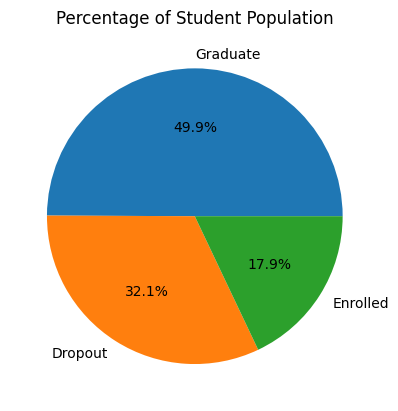

In [144]:
# Calculating the value counts of population
student_target = student_data['Outcome'].value_counts()

# Plotting the pie chart
plt.pie(student_target, labels=student_target.index, autopct='%1.1f%%')
plt.title('Percentage of Student Population')
plt.show()

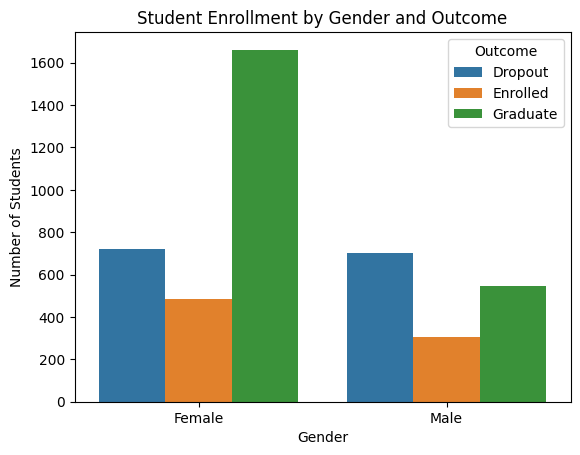

In [145]:
#Comparing the average age of students who are enrolled, graduated, and dropped out
sns.countplot(data=student_data, x='Gender', hue='Outcome', hue_order=['Dropout', 'Enrolled', 'Graduate'])
plt.title('Student Enrollment by Gender and Outcome')
plt.xticks(ticks=[0,1], labels=['Female','Male'])
plt.ylabel('Number of Students')
plt.show()

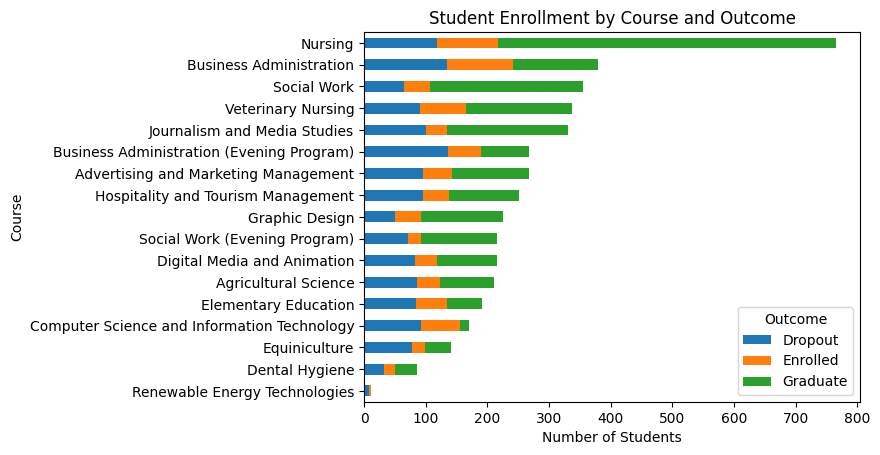

In [146]:
# Grouping the data by 'Course' and 'Outcome'
student_course = student_data.groupby(['Course', 'Outcome']).size().reset_index().pivot(columns='Outcome', index='Course', values=0)

# Renaming the index of the Dataframe
student_course = student_course.rename(index={1:'Renewable Energy Technologies',2:'Digital Media and Animation',3:'Social Work (Evening Program)',4:'Agricultural Science',5:'Graphic Design',6:'Veterinary Nursing',7:'Computer Science and Information Technology',8:'Equiniculture',9:'Business Administration',10:'Social Work',11:'Hospitality and Tourism Management',12:'Nursing',13:'Dental Hygiene',14:'Advertising and Marketing Management',15:'Journalism and Media Studies',16:'Elementary Education',17:'Business Administration (Evening Program)'})
student_course_total = student_course.sum(axis=1)
student_course_sorted = student_course_total.sort_values(ascending=True)
student_course.loc[student_course_sorted.index].plot(kind='barh', stacked=True)

# Adding title and labels
plt.title('Student Enrollment by Course and Outcome', loc='center')
plt.ylabel('Course')
plt.xlabel('Number of Students')
plt.show()

## Correlation Matrix

Using a correlation matrix to identify influential characteristics / variables there is a deeper understanding of the relationships among the dataset's variables. Below are the key insights and implications drawn from this matrix:

Strong positive clusters and negative signals:
* The variables shown in the bottom right move together, along with factors like parent previous qualifications, parent occupation, marital status, nationality, and age at enrollment. Where the negative signals grouped around displaced students, and gender. 

Log-Log Relationship:
* Strong correlations indicate that the logarithmic transformations of these variables maintain proportional changes, essential for predicting scaling behaviors. These transformations can be conducted on variables like the parent previous qualifications listed in the dataset.

    The log-log regression model has the following form:
    
    <code>log(Y) = β<sub>0</sub> + β<sub>1</sub> log(X<sub>1</sub>) + β<sub>2</sub> log(X<sub>2</sub>) + ... + ε</code>
    
    </pre>
    <p>Where:</p>
    <ul>
        <li><code>Y</code> is the dependent variable.</li>
        <li><code>X<sub>1</sub>, X<sub>2</sub>, ...</code> are independent variables.</li>
        <li><code>β<sub>0</sub></code> is the intercept.</li>
        <li><code>β<sub>1</sub>, β<sub>2</sub>, ...</code> are the coefficients (elasticities).</li>
        <li><code>ε</code> is the error term.</li>
    </ul>

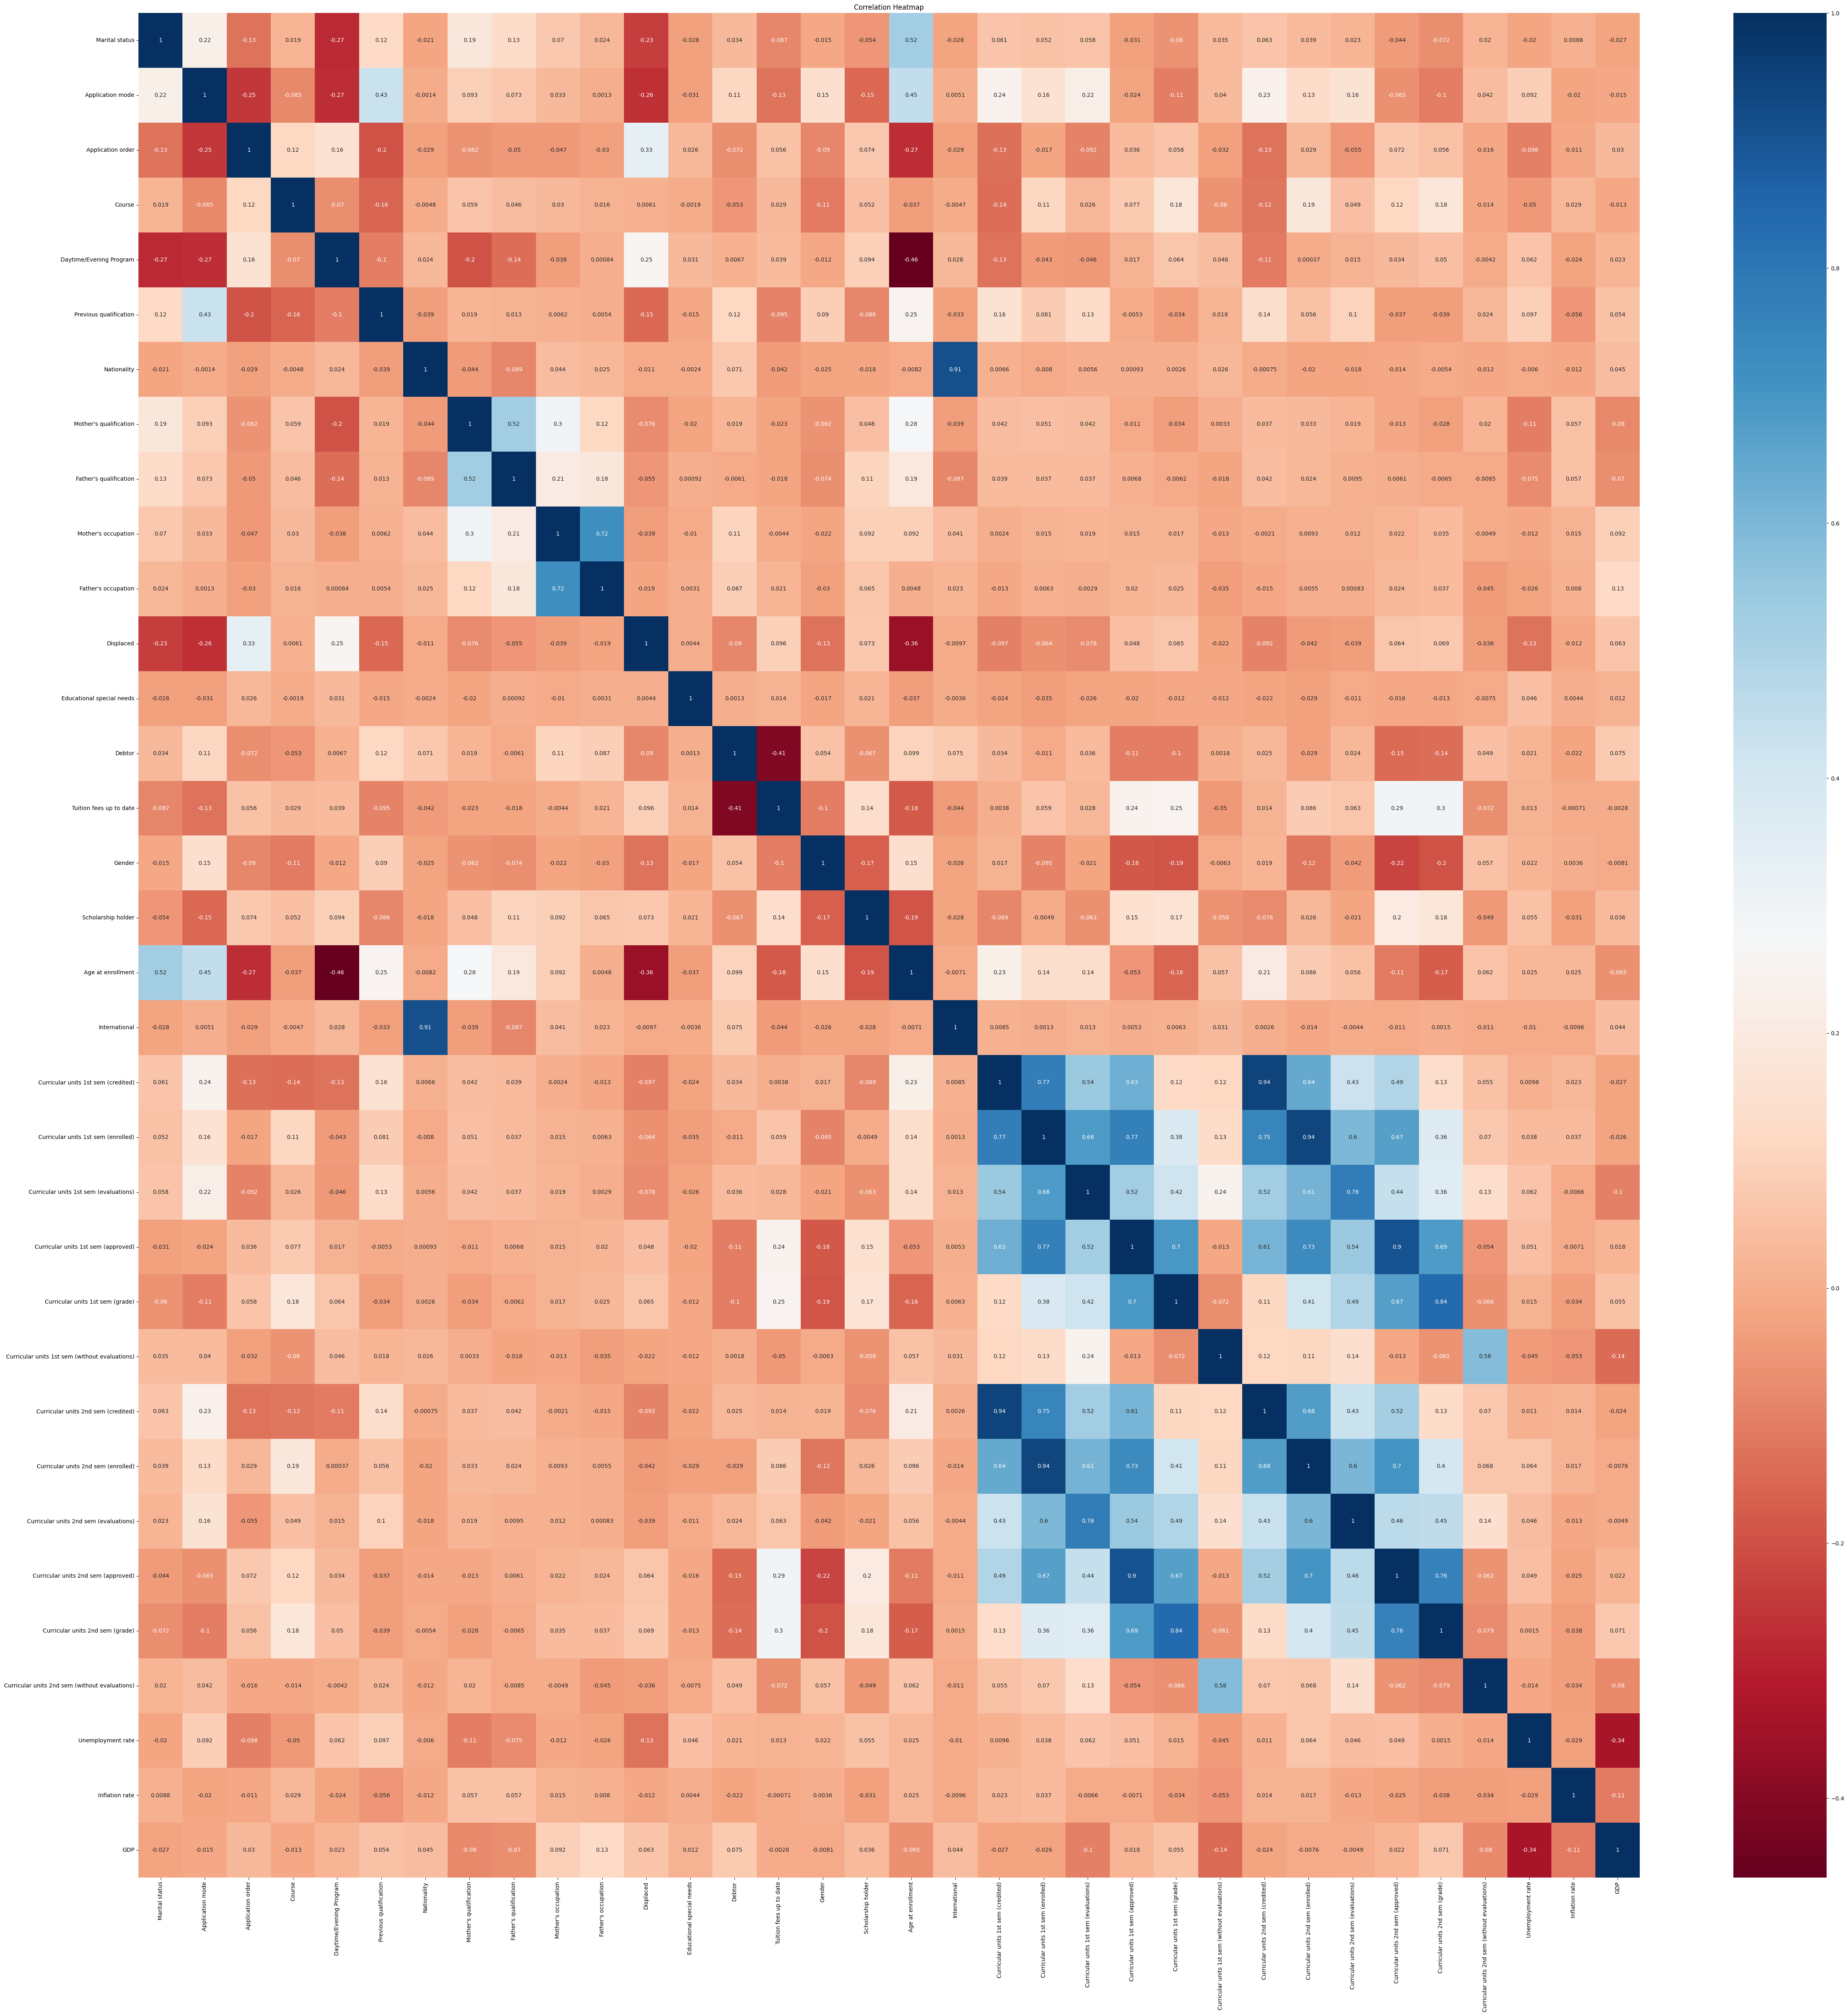

In [147]:
# Select only the numerical columns
numerical_cols_student_data = student_data.select_dtypes(include=['number'])

# Plot the correlation heatmap
plt.figure(figsize=(60, 60))
sns.heatmap(numerical_cols_student_data.corr(), annot=True, cmap='RdBu')
plt.title('Correlation Heatmap', fontsize=12)
plt.yticks(rotation=0)
plt.show()

## Data Preprocessing

The data transformation phase allows for deeper analysis and data modeling. As part of this phase, string values were one-hot encoded due to the non-ordinal values in the dataframe and were reconfigured to have binary columns for each category of the student's status. Grouping of nationalities was completed as part of matching the country IDs to each nationality for additional analysis.

In [148]:
# Create a new dataframe with Nationality column 
data = student_data.copy()

# Define the nationality_ids variable
nationality_ids = data['Nationality']

# Define the id_to_Nationality dictionary
id_to_Nationality = {
    1: 'Portuguese', 2: 'German', 3: 'Spanish', 4: 'Italian', 5: 'Dutch', 
    6: 'English', 7: 'Lithuanian', 8: 'Angolan', 9: 'Cape Verdean', 10: 'Guinean', 
    11: 'Mozambican', 12: 'Santomean', 13: 'Turkish', 14: 'Brazilian', 
    15: 'Romanian', 16: 'Moldova (Republic of)', 17: 'Mexican', 18: 'Ukrainian', 
    19: 'Russian', 20: 'Cuban', 21: 'Colombian'
}
nationality_ids = data['Nationality']

# Map the IDs to their corresponding nationalities
nationalities = nationality_ids.map(id_to_Nationality)

# Map the IDs to their corresponding nationalities
nationalities = nationality_ids.map(id_to_Nationality)

# Add the mapped Nationality to the original DataFrame
data['Nationality'] = nationalities

# Reorder the columns for better readability
grouped_by_nationality = data.groupby('Nationality').size().reset_index(name='Count')

# Display the grouped DataFrame
print(grouped_by_nationality)

              Nationality  Count
0                 Angolan      2
1               Brazilian     38
2            Cape Verdean     13
3               Colombian      1
4                   Cuban      1
5                   Dutch      1
6                 English      1
7                  German      2
8                 Guinean      5
9                 Italian      3
10             Lithuanian      1
11                Mexican      2
12  Moldova (Republic of)      3
13             Mozambican      2
14             Portuguese   4314
15               Romanian      2
16                Russian      2
17              Santomean     14
18                Spanish     13
19                Turkish      1
20              Ukrainian      3


In [149]:
# Check the column name in the DataFrame
if 'Outcome' in student_data.columns:
    student_data = pd.get_dummies(student_data, columns=['Outcome'])

In [150]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/Evening Program                         4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nationality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [151]:
student_data.head()

,Marital status,Application mode,Application order,Course,Daytime/Evening Program,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Outcome_Dropout,Outcome_Enrolled,Outcome_Graduate
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0.000000,0,10.8,1.4,1.74,1,0,0
1,1,6,1,11,1,1,1,1,3,4,...,6,6,13.666667,0,13.9,-0.3,0.79,0,0,1
2,1,1,5,5,1,1,1,22,27,10,...,0,0,0.000000,0,10.8,1.4,1.74,1,0,0
3,1,8,2,15,1,1,1,23,27,6,...,10,5,12.400000,0,9.4,-0.8,-3.12,0,0,1
4,2,12,1,3,0,1,1,22,28,10,...,6,6,13.000000,0,13.9,-0.3,0.79,0,0,1


In [152]:
if 'Nationality' in student_data.columns:
    student_data.copy = student_data.loc[(student_data['Nationality'] == 'Portuguese') | (student_data['Nationality'] == 'Brazilian')]
else:
    print("Column 'Nationality' does not exist in the DataFrame.")


In [153]:
# Check if 'Marital status' and 'Gender' columns exist in the DataFrame
if 'Marital status' in student_data.columns and 'Gender' in student_data.columns:
    X = student_data[['Marital status', 'Gender']].values
    y = student_data['Nationality'].values
else:
    print("Columns 'Marital status' and/or 'Gender' do not exist in the DataFrame.")


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Standardize the data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
# Combine standardized training and test data for plotting
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

## Non-Parametric Model

Instance based learning for this section allows for the model to memorize the training dataset and provides a $0 cost for the machine learning process. There are several metrics that can be chosen for this stage. Below describes in more detail.   

## Minkowski Metric

Minkowski distance was chosen over Euclidean and Manhattan distances because it allows for more flexible comparisons between vectors, particularly when dealing with a mix of integers, floats and string values within this dataset. String values were one-hot encoded due to the non-ordinal values to have binary columns for each category of the student's status, previlously documented in the preprocessing section. The adaptability of the Minkowski distance makes it suitable for analyzing overlapping comparisons in this context. The Minkowski distance is calculated as follows:  
<p>
    <img src="https://latex.codecogs.com/svg.latex?D(X,Y)=\left(\sum_{i=1}^{n}|x_i-y_i|^p\right)^{\frac{1}{p}}" alt="Minkowski Distance">
</p>
<p>Where:</p>
<ul>
    <li><em>n</em> is the number of dimensions</li>
    <li><em>p</em> is the order of the norm (p ≥ 1)</li>
    <li><em>x<sub>i</sub></em> and <em>y<sub>i</sub></em> are the coordinates of points <em>X</em> and <em>Y</em> in dimension <em>i</em></li>
</ul>

In [154]:
# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

KNeighborsClassifier()

In [158]:
churn_x_train = data.loc[y_train, ['Outcome_Dropout', 'Outcome_Enrolled', 'Outcome_Graduate']]
churn_y_train = data.loc[y_train, 'Nationality']
churn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=10))])
churn_pipe.fit(churn_x_train, churn_y_train)
churn_confusion_mat = plot_confusion_matrix(churn_pipe, churn_x_test, churn_y_test)


One or more column names do not exist in the DataFrame.


In [ ]:
    # Define the variable test_idx before using it
    test_idx = None

    # Highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

In [ ]:
## code for figure
x = np.linspace(165, 240, 100)
sns.scatterplot(data = penguins, x = 'flipper_length_mm', y = 'bill_length_mm', hue = 'species')
plt.plot(x, decision_boundary(x, beta_0, beta_1, beta_2), '--', color = 'black')
plt.ylim(25, 65)
plt.fill_between(x, decision_boundary(x, beta_0, beta_1, beta_2), alpha = 0.3, color = 'lightblue')
plt.fill_between(x, decision_boundary(x, beta_0, beta_1, beta_2), np.repeat(70, 100), alpha = 0.3)

In [ ]:
# Define the colors for the colormap
colors = ['red', 'blue', 'green', 'yellow']

# Define the colormap
cmap = ListedColormap(colors[:len(np.unique(y))])

# Plot the decision surface
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                       np.arange(x2_min, x2_max, resolution))
Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
Z = Z.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, alpha=0.10, cmap=cmap)
plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())


## New Test Section

In [ ]:
student_target = student_data['Outcome'].value_counts()
print(student_target)

In [ ]:
if 'Nationality' in student_data.columns:
    student_data_df = pd.DataFrame(student_data['Nationality'])
    print(student_data_df)
else:
    print("Column 'Marital Status' does not exist in the dataframe.")

In [ ]:
if 'Marital status' in student_data.columns:
    student_data_df = pd.DataFrame(student_data['Marital status'])
    print(student_data_df)
else:
    print("Column 'Marital Status' does not exist in the dataframe.")


In [ ]:
print(student_data.columns)

In [ ]:
counter = 1
numerical_col_fig=plt.figure()
for col in student_data.columns:
    ax1=numerical_col_fig.add_subplot(4,2,counter)   
    ax1.set_title(col + " Histogram", fontsize = 10)
    counter = counter + 1
    student_data[col].hist(bins=40,ax=ax1,alpha=0.5, figsize = (20, 20), color = 'blue')

plt.show()

In [ ]:
# Analysis of the changes over time

student_data=df_final.drop(['Scoring Average_TOTAL ROUNDS','Ball Speed_AVG.','SG: Tee-to-Green_SG:OTT','SG: Tee-to-Green_SG:ARG','SG: Tee-to-Green_SG:APR',
           'SG: Putting_TOTAL SG:PUTTING','Rough Tendency_%'], axis = 1)

f, ax = plt.subplots(nrows = 7, ncols = 3, figsize=(35,65))
distribution =df_final2.loc[:,(df_final2.columns!='Wins')].columns
distribution = distribution[distribution != 'Year']

print(distribution)
rows = 0
cols = 0
for i, column in enumerate(distribution):
    p = sns.boxplot(x = 'Year', y = column, hue='Win',data=df_final2, ax=ax[rows][cols], showfliers=False,showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"7"},)
    p.set_ylabel(column,fontsize=20)
    p.set_xlabel('Year',fontsize=20)
    cols += 1
    if cols == 3:
        cols = 0
        rows += 1

In [ ]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))



## Analysis

In [ ]:
# Ensure all rows with zero or negative values are removed for log transformation
data_reg = student_data[(student_data['Curricular units 2nd sem (grade)'] > 0) & 
                (student_data['GDP'] > 0) & 
                (student_data['Gender'] > 0)]

In [ ]:
# Log transformation
data_reg['log_grade'] = np.log(data_reg['Curricular units 2nd sem (grade)'])
data_reg['log_gdp'] = np.log(data_reg['GDP'])
data_reg['log_gender'] = np.log(data_reg['gender'])

# Define independent and dependent variables
X = data_reg[['log_gdp', 'log_unemployment_rate']]
y = data_reg['log_grade']


In [ ]:
# Initialize the linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Retrieve the model coefficients
intercept = model.intercept_
coefficients = model.coef_

# Display the model coefficients
print("Intercept:", intercept)
print("Coefficients:", coefficients)

In [ ]:
# Plotting the results
plt.scatter(data_reg['log_gdp'], data_reg['log_grade'], label='Log GDP')
plt.scatter(data_reg['log_unemployment_rate'], data_reg['log_grade'], label='Log Unemployment Rate', color='orange')
plt.plot(data_reg['log_gdp'], model.predict(X), color='red', label='Fitted Line')
plt.xlabel('Log of Independent Variables')
plt.ylabel('Log of Curricular Units 2nd Sem (Grade)')
plt.title('Log-Log Regression with Scikit-Learn')
plt.legend()
plt.show()